In [1]:
import os
import glob
import pandas as pd
import plotly as py
import cufflinks as cf
%matplotlib inline

In [2]:
path_to_csv = "/home/SharedFolder/trained_models/night-drive/weather_classifier/with_cloudy/train_A_over_ganaug_025"
plot_title = "train_A_over_ganaug_025"

In [3]:
csv_files = glob.glob(path_to_csv + "/*.csv")

### Combine CSVs into one DataFrame ###

In [4]:
df = pd.DataFrame()
for csv_file in csv_files:
    df = pd.concat([df, pd.read_csv(csv_file)], axis = 0)
df = df.reset_index(drop = True)

### Some preprocessing ###

In [5]:
df = df.drop(columns = ["weights"])
df.head()

,epoch,data,f1_score_weighted,f1_score_micro,f1_score_macro,accuracy,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,1,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.468326,0.386,0.307589,0.386,0.665244,0.722769,0.415928,0.459654,0.171660
1,2,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.504281,0.428,0.365662,0.428,0.725823,0.763355,0.466438,0.534247,0.229055
2,3,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.620804,0.548,0.442484,0.548,0.813031,0.789679,0.588983,0.591168,0.292752
3,4,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.642323,0.578,0.462176,0.578,0.832297,0.798382,0.634094,0.605764,0.309846
4,5,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.680736,0.623,0.486767,0.623,0.858663,0.804209,0.684655,0.616337,0.340123


In [6]:
df.data = df.data.apply(lambda x: x.split(os.sep)[-1].split(".json")[0].split("bdd100k_sorted_")[-1])
df = df.sort_values(by = ["data", "epoch"])
df = df.reset_index(drop = True)
df.head()

,epoch,data,f1_score_weighted,f1_score_micro,f1_score_macro,accuracy,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,1,test,0.569719,0.5495,0.512846,0.5495,0.809467,0.830506,0.630193,0.654845,0.363416
1,2,test,0.612625,0.5960,0.566830,0.5960,0.850502,0.868567,0.689166,0.723962,0.433133
2,3,test,0.683285,0.6695,0.634704,0.6695,0.892931,0.893968,0.758819,0.766656,0.512930
3,4,test,0.698238,0.6865,0.647873,0.6865,0.899672,0.900713,0.774478,0.779487,0.533664
4,5,test,0.721224,0.7100,0.666769,0.7100,0.910328,0.905878,0.794202,0.788784,0.559955


### Load training log file ###

In [7]:
train_log_file = glob.glob(path_to_csv + "/*.txt")
assert(len(train_log_file) == 1)

In [8]:
df_loss = pd.read_csv(train_log_file[0], sep = " ", header = None, skiprows = [0, 1])
df_loss.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,Epoch,"1/40,",Batch,10/401:,Train,Loss,=,1.551,Valid,Loss,=,1.537,ETA,=,7.02h
1,Epoch,"1/40,",Batch,20/401:,Train,Loss,=,1.501,Valid,Loss,=,1.512,ETA,=,6.34h
2,Epoch,"1/40,",Batch,30/401:,Train,Loss,=,1.470,Valid,Loss,=,1.477,ETA,=,5.26h
3,Epoch,"1/40,",Batch,40/401:,Train,Loss,=,1.429,Valid,Loss,=,1.416,ETA,=,5.47h
4,Epoch,"1/40,",Batch,50/401:,Train,Loss,=,1.410,Valid,Loss,=,1.384,ETA,=,5.27h


In [9]:
df_loss = df_loss.iloc[:, [1, 3, 7, 11]].rename(columns = {1: "epoch", 3: "batch", 7: "train_loss", 11: "train_dev_loss"})
df_loss.epoch = df_loss.epoch.apply(lambda x: int(x.split("/")[0]))
df_loss.batch = df_loss.batch.apply(lambda x: int(x.split("/")[0]))
df_loss["global_batch"] = (df_loss.epoch - 1) * df_loss.batch.max() + df_loss.batch
df_loss = df_loss.sort_values(by = ["epoch", "batch"]).set_index("global_batch", drop = True)
df_loss.head()

,epoch,batch,train_loss,train_dev_loss
global_batch,,,,
10,1,10,1.551,1.537
20,1,20,1.501,1.512
30,1,30,1.470,1.477
40,1,40,1.429,1.416
50,1,50,1.410,1.384


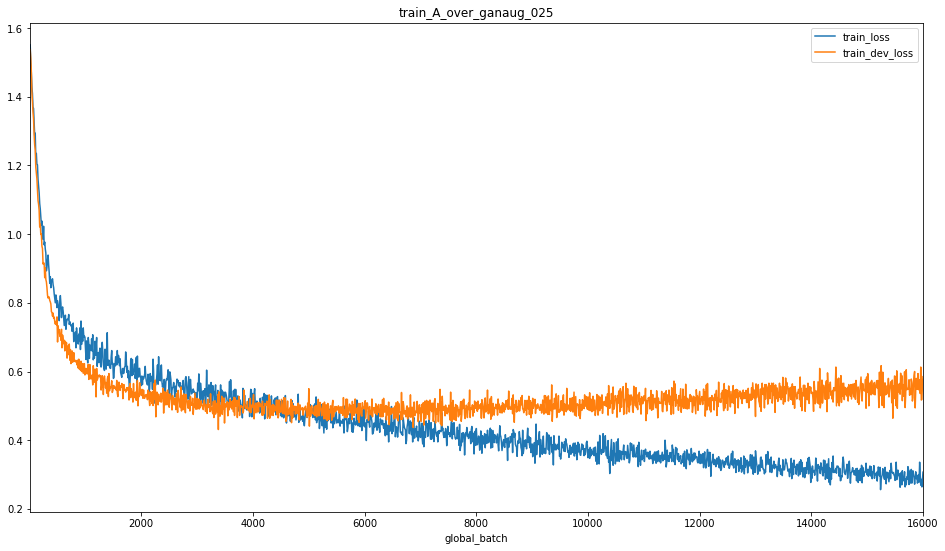

In [10]:
df_loss.plot(y = ["train_loss", "train_dev_loss"], title = plot_title, figsize = (16, 9))

### Combine loss, scores  and plot ###

In [11]:
df_combined = df_loss.groupby(by = ["epoch"]).median()
df_combined = df_combined.drop(columns = ["batch"])
df_combined.head()

,train_loss,train_dev_loss
epoch,,
1,1.0445,1.0000
2,0.7605,0.6870
3,0.6880,0.6045
4,0.6270,0.5590
5,0.5990,0.5460


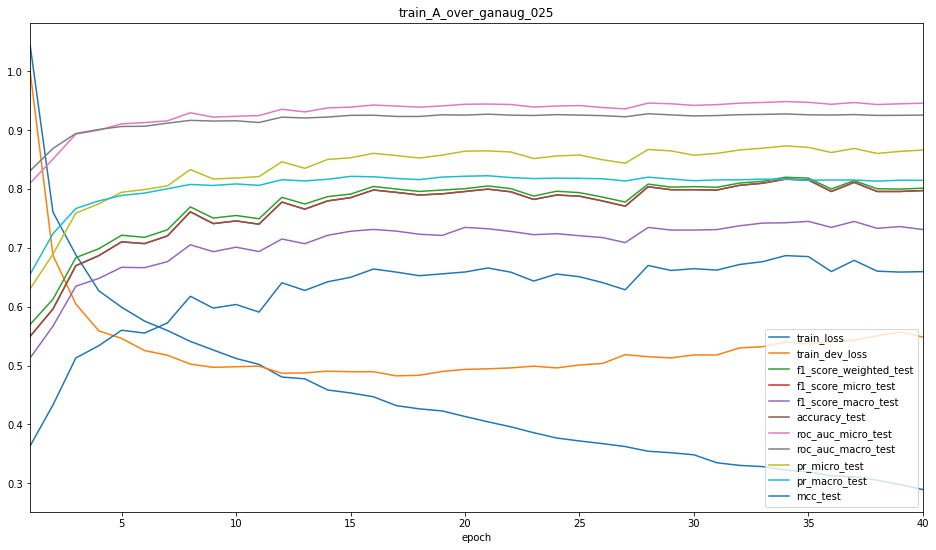

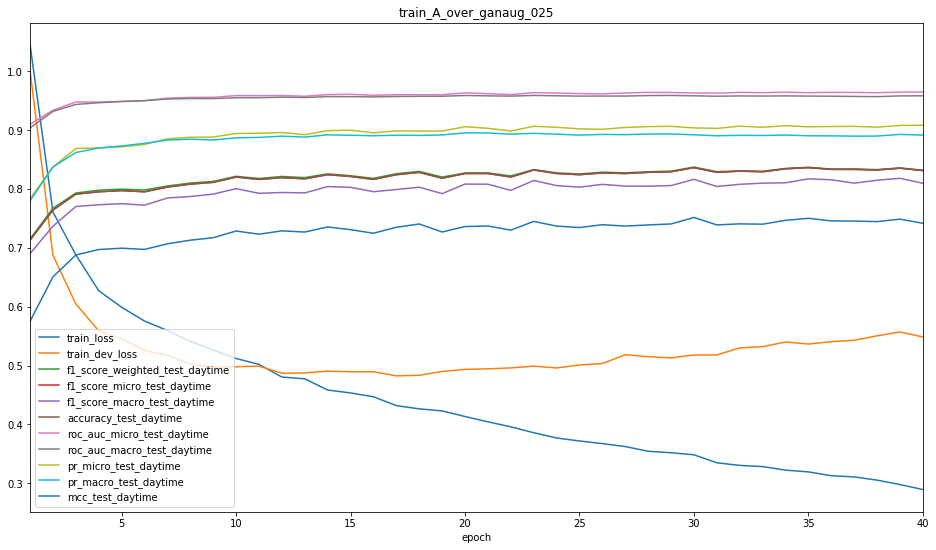

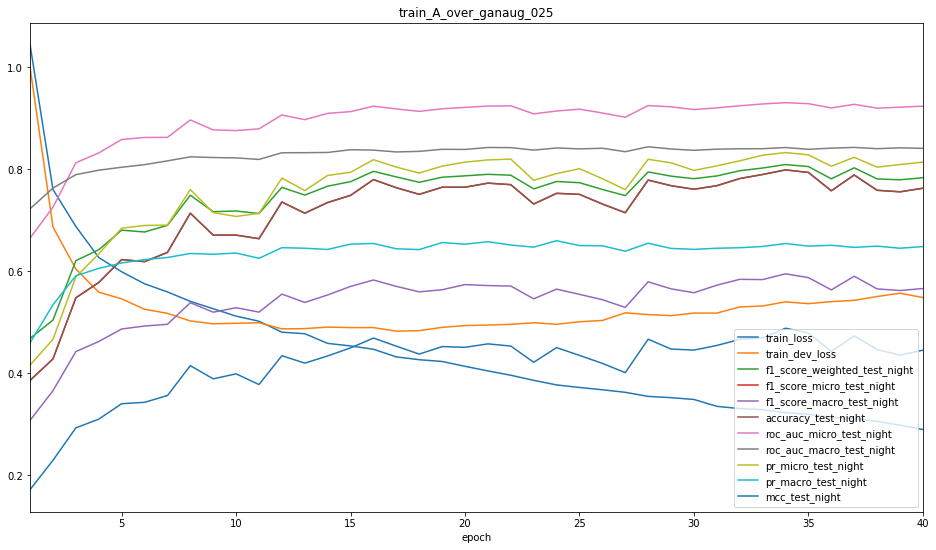

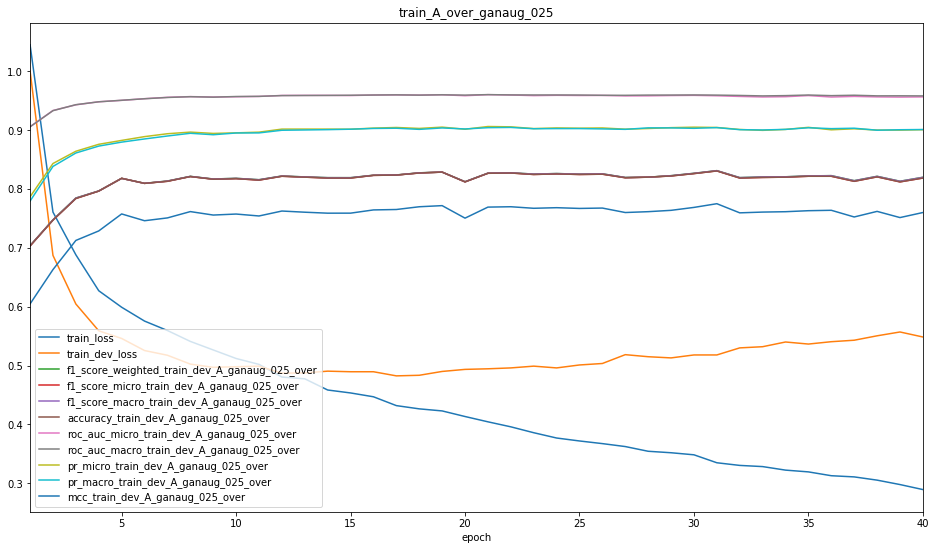

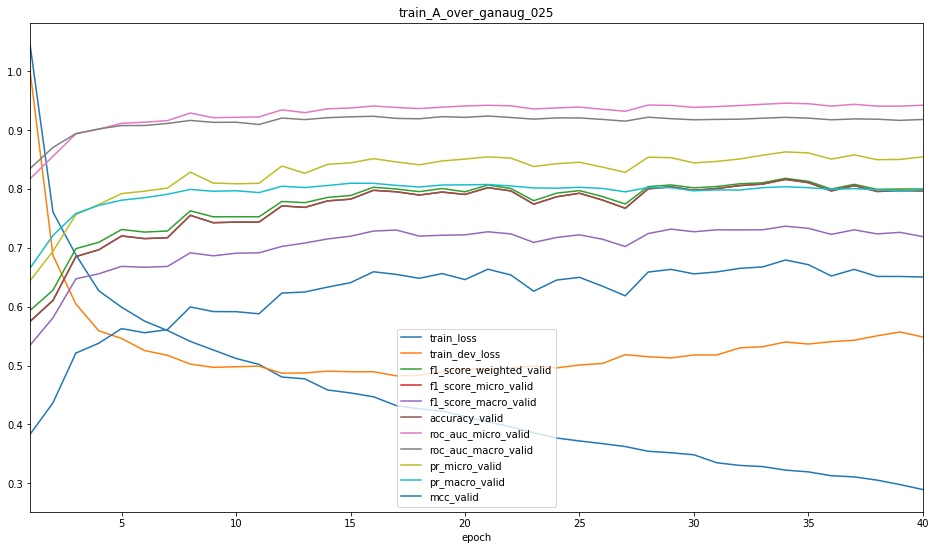

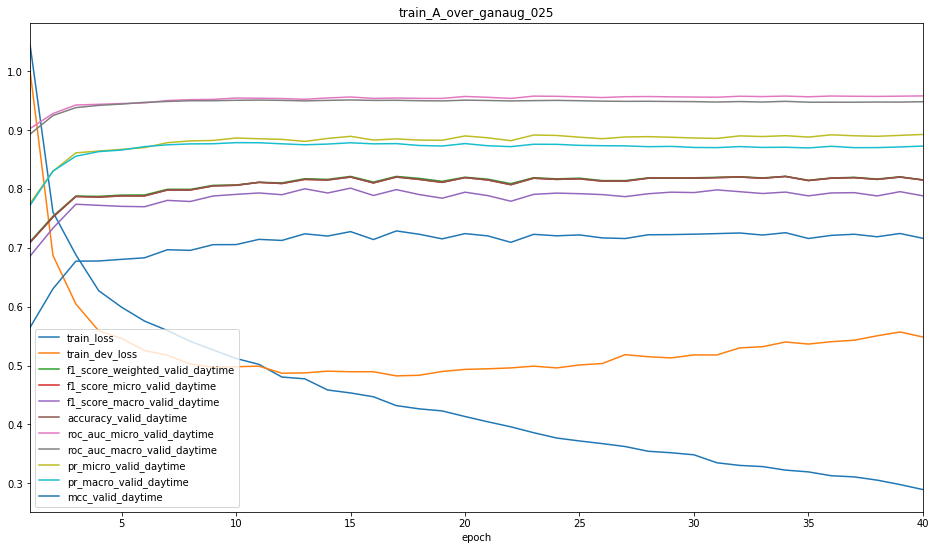

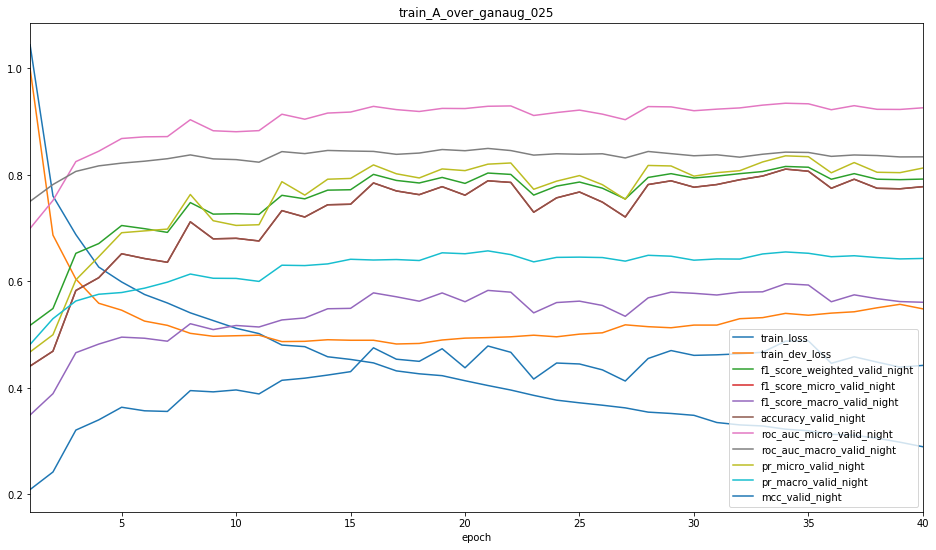

In [12]:
for data in df.data.unique():
    df_data = df.loc[df.data == data]
    df_data = df_data.drop(columns = ["data"])
    df_data = df_data.set_index("epoch", drop = True)
    df_data = df_data.add_suffix("_" + data)
    df_combined_data = df_combined.merge(df_data, on = "epoch")
    df_combined_data.plot(title = plot_title, figsize = (16, 9))

### Interactive Plotly Plots ##

In [13]:
cf.go_offline(connected = True)
config = {
    "modeBarButtonsToRemove": ["sendDataToCloud"],
    "displaylogo": False
}
layout = {
    "title": plot_title,
    "xaxis": {
        "title": "epoch"
    },    
    "width": 960,
    "height": 540
}
for data in df.data.unique():
    df_data = df.loc[df.data == data]
    df_data = df_data.drop(columns = ["data"])
    df_data = df_data.set_index("epoch", drop = True)
    df_data = df_data.add_suffix("_" + data)
    df_combined_data = df_combined.merge(df_data, on = "epoch")
    fig = df_combined_data.iplot(layout = layout, asFigure = True)
    py.offline.iplot(fig, show_link = False, config = config)